## Kernel density estimation & non-parametric regression

#### *2 October 2019*
#### *DATA 1010*

<img src="tricube-100.svg" style="float: right; width: 250px">

We want to estimate the joint probability density function $f(x,y)$ of two random variables $X$ and $Y$, based on a given set of observations $\{X_i,Y_i\}_{i=1}^n$. The key idea for **kernel density estimation** is to spread out a $1/n$ probability mass around each observation. In mathematical terms, our estimator is 

$$\hat{f}_{\lambda}(x,y) = \frac{1}{n} \sum_{i=1}^n K_{\lambda}(x-X_i, y-Y_i)$$

The *kernel* $K_\lambda$ is defined as a product $K_{\lambda}(x,y) = D_{\lambda}(x)D_{\lambda}(y)$.

### Problem 1
 
Suppose that $D_\lambda: \mathbb{R} \to \mathbb{R}$ is a function whose support is equal to $[-\lambda,\lambda]$. What is the support of $K_\lambda(x,y) = D_\lambda(x)D_\lambda(y)$?

(Note: the support of a function is the set of all points where the function is nonzero, together with the boundary of that set.)

*Write your solution here*

---

It usually doesn't matter too much what the shape of our kernel is. Let's use the *tricube* function:

$$D(u) = \frac{70}{81} ( 1 - |u|^3)^3 \boldsymbol{1}_{|u|\leq 1}.$$ 

Some other functions used include the Normal density and the triangular function:

$$ D(u) =  \frac{1}{\sqrt{2\pi}}e^{-\frac{u^2}{2}}, \quad D(u) = (1 - |u|)\boldsymbol{1}_{|u|\leq 1}.$$

### Problem 2

Write a Julia function to estimation joint probability density $\hat{f}_{\lambda}(x,y)$ using the Normal function. Plot your result. Experiment with various values of $\lambda$.

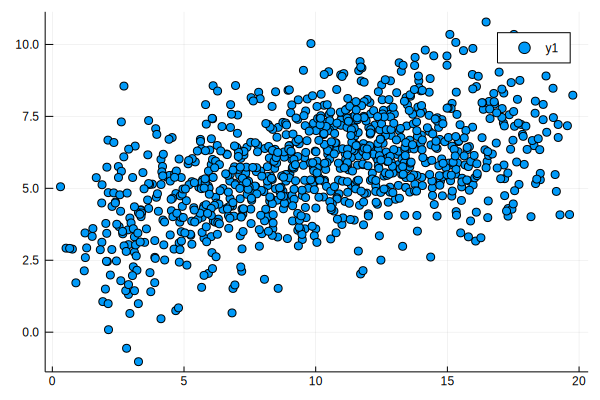

In [ ]:
using LinearAlgebra, Statistics, Roots, Optim, Plots, Random

Random.seed!(1234)

function kdenorm(sample, λ)
    # fill in the blanks and uncomment
    #D(u) = EXPRESSION_HERE
    #D(λ,u) = 1/λ * D(u/λ)
    #K(λ,x,y) = D(λ,x) * D(λ,y)
    #kde(λ,x,y,sample) = sum(K(λ,x-Xi,y-Yi) for (Xi,Yi) in sample)/length(sample)
    
    #scatter(sample, markerstrokewidth=0, markersize=2, label = "",
    #        color = :DarkRed)
    #heatmap!(0:0.1:20, -2:0.1:12, (x,y) -> EXPRESSION_HERE, 
    #         opacity = 0.5, color = cgrad([:white, :MidnightBlue, :Gold]))
end


# True regression function
r(x) = 2 + 1/50*x*(30-x)

# True density function
σy = 3/2  
f(x,y) = 3/4000 * 1/√(2π*σy^2) * x*(20-x)*exp(-1/(2σy^2)*(y-r(x))^2)

# F(t) is the CDF of X
F(t) = -t^3/4000 + 3t^2/400

# Sample from the distribution of X (inverse CDF trick)
function sampleX()
    U = rand()
    find_zero(t->F(t)-U,(0,20),Bisection())
end

# Sample from joint distribution of X and Y
function sampleXY(r, σ)
    X = sampleX()
    Y = r(X) + σ*randn()
    (X,Y)
end

n = 1000 # number of observations in the sample

# Sample n observations
sample = [sampleXY(r,σy) for i=1:n]

# Estimate density
kdenorm(sample, 1)

---

You might have been able to choose a favorite $\lambda$ in this exercise by looking at the plots. But clearly we are going to want a better approach. 

To find the optimal value of $\lambda$, we minimize the mean integrated squared error (MISE): $\int (\hat{f}_\lambda - f)^2$.

Expanding, we realize that this amounts to minimizing: $\int \hat{f}^2_{\lambda} -2 \int \hat{f}_{\lambda}f $

Although the term $-2 \int \hat{f}_{\lambda}f$ has an $f$ in it (and we don't know $f$), we can still estimate this expression from data $(X_i,Y_i)_{i=1}^{n}$, using the following idea: recall from probability that if $g$ is a function and $f_X$ is the PDF of a random variable $X$, then $\int gf_X = \mathbb{E}[g(X)]$. We can do the same thing but throw in another random variable $Z$ to condition on: if $g$ is a function that depends on *two* random variables $X$ and $Z$, then we have $\int g(x,Z) f_{X | Z}(x,Z) \operatorname{d} x = \mathbb{E}[g(X,Z)|Z]$. 

If $X$ and $Z$ are independent, then this reduces to $\int g(x,Z) f_{X}(x) = \mathbb{E}[g(X,Z)|Z]$ By the law of large numbers, $\mathbb{E}[g(X)|Z]$ can be approximated by an average of $n$ samples from its distribution.

We'll apply that idea here, with $\widehat{f}_\lambda$ as our random function $g$ and with $X_1, \ldots, X_n$ as our random observations from the density function $f$ (this is really the key step: the only access we have to $f$ is through the observations). Note that $\widehat{f}_\lambda$ depends on $X_1, \ldots, X_n$, so to start out, let's try $Z = [X_1, \ldots, X_n]$. 

The problem with this setup is that $Z$ and $X_i$ are not independent (since $X_i$ is one of the components of $Z$). Therefore, we define $\hat{f}_{\lambda}^{(-i)}$ to be the estimator obtained from the original data set with the $i$th observation removed. So now we can use $Z = [X_1, \ldots, X_{i-1}, X_{i+1}, X_n]$, and $Z$ *is* independent of $X$. So we can sample from the distribution of $\mathbb{E}[g(X,Z)|Z]$ by evaluating $\hat{f}_{\lambda}^{(-i)}(X_i)$ (in other words, form the estimator without looking at the $i$th sample, and then plug the $i$th sample into that estimator). Thus we arrive at the quantity we will seek to minimize:

$$
\hat{J}(\lambda) = \int \hat{f}^2_{\lambda} - \frac{2}{n}\sum_{i=1}^n \hat{f}_{\lambda}^{(-i)}(X_i,Y_i).
$$ 

## Problem 3

Suppose that $f$ is the standard normal density on $\mathbb{R}$, and $\widehat{f}$ is the kernel density estimator based on the tricube kernel with $\lambda = 1$. Compare $\int \widehat{f} f$ to $\frac{1}{n}\sum_{i=1}^n \widehat{f}^{(-i)}(X_i)$, where $X_1, \ldots, X_{n}$ are independent random variables with distribution given by $f$. 

Experiment with different values of $n$ and $\lambda$. 

In [ ]:
using LaTeXStrings, Random; Random.seed!(123)
n = 10
λ = 0.5
X = randn(n)
tricube(x) = abs(x) ≤ 1 ? 70/81 * (1-abs(x)^3)^3 : 0
tricube(λ, x) = tricube(x/λ)/λ
# f̂(λ,X,x) = KERNEL DENSITY ESTIMATOR
# f̂(λ,X,i,x) = LEAVE ONE OUT ESTIMATOR AT x
f(x) = pdf(Normal(0,1), x)
# plot(-3:0.01:3, x -> f̂(λ,X,x), label = L"\widehat{f}_{\lambda}")
plot!(-3:0.01:3, f, label = "true density")

---

## Non-parametric regression

Next, we estimate the regression function $r(x) = \mathbb{E}[Y | X = x]$ by integration the estimate for the conditional density $\hat{f}_{Y | X=x}(x)$.

Note that:
$ \hat{f}_{Y|X=x} = \frac{\hat{f}(x,y)}{\int \hat{f}(x,y) dy} $ and $r(x) = \int y \hat{f}_{Y|X=x}(x) $

Substituting the formula for our estimate $\hat{f}$, we find that:

$$ \hat{r}(x) = \frac{\sum_{i=1}^n D_{\lambda}(x-X_i)Y_i}{\sum_{i=1}^n D_{\lambda}(x-X_i)}.$$

### Problem 4

(a) Plot the regression function using various values of $\lambda$.

(b) What tradeoffs do you notice when $\lambda$ is increased or decreased?

(c) What's the smallest integrated squared error you can come up with?

In [ ]:
λ = 2.0
# r̂(λ,x) = Nadaraya-Watson estimator
plot(0:0.01:20, x->r̂(λ,x), label = "Nadaraya-Watson estimator", ylims = (0,10), linewidth = 2, color = :Red)
plot!(0:0.2:20, r, label = "actual regression function", linewidth = 2, color = :MidnightBlue)

In [ ]:
# ISE_error = approximate squared error between r(x) and r̂(x) 

---

### Problem 5 (Challenge)



We tackle the problem of estimating the variance for our regression estimate $\hat{r}(x)$.

Suppose, $Y_i = \hat{r}(X_i) + \epsilon_i$

In expectation, the error term is $0$, i.e. $\mathbb{E}[\epsilon_i | X_i] = 0$

Lets assume a variance function $\sigma^2$ such that:
$$ \epsilon_i^2 = \sigma^2(X_i) + \eta_i $$

where $\mathbb{E}[\eta_i | X_i] = 0$

Write Julia code to compute the squared error $\epsilon_i^2$ at each point $(X_i,Y_i)$ and estimate the function $\sigma^2$ using KDE. Plot $\hat{r}(x)$ and a $95\%$ shaded confidence region between $\hat{r}(x) - 1.96\hat{\sigma}(x)$ and $\hat{r}(x) + 1.96\hat{\sigma}(x)$.